In [1]:
from collections import Counter
import pickle
import os
import yaml
import random
import numpy as np
import pandas as pd

from time import time
import matplotlib.pyplot as plt

from scipy.stats import bernoulli, gaussian_kde
from sklearn import decomposition


import matplotlib.pyplot as plt

os.chdir(os.path.expanduser("~/projects/embedding/src"))
from probe2vec.w2v import word2vec, Word2VecEmbedder
from probe2vec.dataset_reader import DatasetReader
from probe2vec.embedding_utils import build_index, most_similar, merge_counters, reshape_to_vector, SequenceParser
from probe2vec.theano_minibatcher import (
    TheanoMinibatcher, NoiseContrastiveTheanoMinibatcher
)

In [2]:
# get the model file params
%matplotlib inline

config_dir = os.path.expanduser('~/projects/embedding/src/config_yamls/atac_kmer_models/')
results_dir = os.path.expanduser('~/projects/embedding/results/GM12878_atac/distal_seq_kernel/k_6_s_1')
model_yaml = 'k_6_s_1_distal.yaml'
with open(os.path.join(config_dir, model_yaml)) as f:
    params = yaml.load(f)

In [3]:
# load the embedder
ChIP_data_dir = os.path.expanduser('~/projects/SeqDemote/data/ChIP/GM12878/chip_fasta_files')
os.chdir(os.path.expanduser("~/projects/embedding/src"))

## Set up the machinery for reading, parsing, and embedding sequences

In [4]:
my_sp = SequenceParser(**params)

# load the DatasetReader object from the save dir
reader = DatasetReader(files=[], directories=[], skip=[], noise_ratio=15, 
                      t=1e-5, num_processes=3, 
                      unigram_dictionary=None, 
                      min_frequency=0, kernel=[1, 2, 3, 
                      4, 5, 5, 4, 3, 2, 1], 
                      load_dictionary_dir=params['save_dir'], 
                      max_queue_size=0, 
                      macrobatch_size=20000, 
                      parser=my_sp, 
                      verbose=True, k=params['K'], 
                      stride=params['stride'])
    
# load the embedder, DatasetReader objects
batch_size = 1000
noise_ratio=15
num_embedding_dimensions=params['num_embedding_dimensions']
full_batch_size = batch_size * (1 + noise_ratio)

minibatcher = NoiseContrastiveTheanoMinibatcher(
    batch_size=batch_size,
    noise_ratio=noise_ratio,
    dtype="int32",
    num_dims=2
)

embedder = Word2VecEmbedder(input_var=minibatcher.get_batch(),
                            batch_size=full_batch_size,
                            vocabulary_size=reader.get_vocab_size(),
                            num_embedding_dimensions=num_embedding_dimensions)
embedder.load(os.path.join(params['save_dir'],''))
params['save_dir']

Loading dictionary from ../results/GM12878_atac/distal_seq_kernel/k_6_s_1...
pruning dictionary to eliminate tokens occuring less than 0 times.
dropped  0  tokens in pruning the unigram dictionary


'../results/GM12878_atac/distal_seq_kernel/k_6_s_1'

In [5]:
# Load a random set of probes from a randomly chosen factor, embed, and visualize the probes
def sample_from_factor(filename, percentage=0.5):
    tokenized_sentences = my_sp.parse(filename) 
    samples = bernoulli.rvs(percentage,size=len(tokenized_sentences)).astype('bool').tolist()
    return [s for s,i in zip(tokenized_sentences,samples) if i], [s for s,i in zip(tokenized_sentences,samples) if not i]
    

# Sample several factors from the ChIP data

Here is the recipe for orthogonal validation of an embedding model via ChIP data:
- choose a set of five factors
- sample sequences from the peaks
- sample sequences from the flanks
- transform sequences into embedding space to get the embedded features
- transform sequences via CountVectorizer -> RandomProjection to get the direct from sequence features
- push both through a pipeline for classification of peaks from flanks

In [13]:
# choose the factor
factors = os.listdir(ChIP_data_dir)
random.shuffle(factors)
my_factors = factors[0:5]

factor_dict = {}
for factor in my_factors:
    peaks_files = [f for f in os.listdir(os.path.join(ChIP_data_dir,factor)) if f.endswith("peaks.fa")]
    peak_file = os.path.join(ChIP_data_dir,factor,peaks_files[0])
    flank_files = [f for f in os.listdir(os.path.join(ChIP_data_dir,factor)) if f.endswith("flanks.fa")]
    flank_file = os.path.join(ChIP_data_dir,factor,flank_files[0])

    # sample peak, flank sequences
    percentage = 0.8
    training_peaks, validation_peaks = sample_from_factor(peak_file, percentage)
    training_flanks, validation_flanks = sample_from_factor(flank_file, percentage)
    
    factor_dict[factor] = [(training_peaks, validation_peaks),(training_flanks, validation_flanks)]

### Package up the data set

For each factor in the factor dict:

1. Embed the peaks, flanks into the embedding space
2. Form the peaks, flanks into a numpy array, and make the labels
3. Embed the peaks, flanks by random projection 

In [14]:
training_embedded_factor_dict = {}

for f in factor_dict:
    (training_peaks, validation_peaks), (training_flanks, validation_flanks) = factor_dict[f]
    

    # Embed each of the k-mers from the sample sentences, and the other sentences
    embedded_peaks = []
    embedded_peaks_means = []
    for count, peak in enumerate(training_peaks):
        peak_token_ids = [reader.unigram_dictionary.get_id(token) for token in peak]
        embedded_tokens = [embedder.embed(t) for t in peak_token_ids]
        embedded_peaks.append(embedded_tokens)
        embedded_peaks_means.append(np.concatenate(embedded_tokens).mean(axis=0))

    training_peak_X = np.stack(embedded_peaks_means)

    embedded_flanks = []
    embedded_flanks_means = []
    for count, flank in enumerate(training_flanks):
        flank_token_ids = [reader.unigram_dictionary.get_id(token) for token in flank]
        embedded_tokens = [embedder.embed(t) for t in flank_token_ids]
        embedded_flanks.append(embedded_tokens)
        embedded_flanks_means.append(np.concatenate(embedded_tokens).mean(axis=0))

    training_flank_X = np.stack(embedded_flanks_means)

    training_peak_labels = np.ones((len(training_peaks),))
    training_flank_labels = np.zeros((len(training_flanks),))
    print("training peaks shape: ", training_peak_X.shape)
    print("training flanks shape:", training_flank_X.shape)

    X_train_embedded = np.concatenate((training_peak_X,training_flank_X))
    Y_train_labels = np.concatenate((training_peak_labels,training_flank_labels))

    training_embedded_factor_dict[f] = (X_train_embedded,Y_train_labels)
    print("Shape of the training data: ", X_train_embedded.shape)
    print("Shape of the training labels: ", Y_train_labels.shape)

Warning, unrecognized token: GGCGCN
Warning, unrecognized token: GCGCNN
Warning, unrecognized token: CGCNNN
Warning, unrecognized token: GCNNNN
Warning, unrecognized token: CNNNNN
training peaks shape:  (6346, 100)
training flanks shape: (12361, 100)
Shape of the training data:  (18707, 100)
Shape of the training labels:  (18707,)
Warning, unrecognized token: NNNNNG
Warning, unrecognized token: NNNNGA
Warning, unrecognized token: NNNGAA
Warning, unrecognized token: NNGAAT
Warning, unrecognized token: NGAATT
training peaks shape:  (5382, 100)
training flanks shape: (9873, 100)
Shape of the training data:  (15255, 100)
Shape of the training labels:  (15255,)
Warning, unrecognized token: NNNNNG
Warning, unrecognized token: NNNNGT
Warning, unrecognized token: NNNGTC
Warning, unrecognized token: NNGTCA
Warning, unrecognized token: NGTCAC
Warning, unrecognized token: GGCGCN
Warning, unrecognized token: GCGCNN
Warning, unrecognized token: CGCNNN
Warning, unrecognized token: GCNNNN
Warning, un

In [15]:
validation_embedded_factor_dict = {}

for f in factor_dict:
    (training_peaks, validation_peaks), (training_flanks, validation_flanks) = factor_dict[f]

    embedded_peaks = []
    embedded_peaks_means = []
    for count, peak in enumerate(validation_peaks):
        peak_token_ids = [reader.unigram_dictionary.get_id(token) for token in peak]
        embedded_tokens = [embedder.embed(t) for t in peak_token_ids]
        embedded_peaks.append(embedded_tokens)
        embedded_peaks_means.append(np.concatenate(embedded_tokens).mean(axis=0))

    validation_peak_X = np.stack(embedded_peaks_means)

    embedded_flanks = []
    embedded_flanks_means = []
    for count, flank in enumerate(validation_flanks):
        flank_token_ids = [reader.unigram_dictionary.get_id(token) for token in flank]
        embedded_tokens = [embedder.embed(t) for t in flank_token_ids]
        embedded_flanks.append(embedded_tokens)
        embedded_flanks_means.append(np.concatenate(embedded_tokens).mean(axis=0))

    validation_flank_X = np.stack(embedded_flanks_means)

    validation_peak_labels = np.ones((len(validation_peaks),))
    validation_flank_labels = np.zeros((len(validation_flanks),))
    print("Validation peak shape: ", validation_peak_X.shape)
    print("Validation flank shape:", validation_flank_X.shape)

    X_validation_embedded = np.concatenate((validation_peak_X, validation_flank_X))
    Y_validation_labels = np.concatenate((validation_peak_labels, validation_flank_labels))

    print("Shape of the validation data: ", X_validation_embedded.shape)
    print("Shape of the validation labels: ", Y_validation_labels.shape)
    
    validation_embedded_factor_dict[f] = (X_validation_embedded, Y_validation_labels)

Warning, unrecognized token: NNNNTG
Warning, unrecognized token: NNNTGG
Warning, unrecognized token: NNTGGG
Warning, unrecognized token: NTGGGG
Validation peak shape:  (1553, 100)
Validation flank shape: (3061, 100)
Shape of the validation data:  (4614, 100)
Shape of the validation labels:  (4614,)
Warning, unrecognized token: GGCGCN
Warning, unrecognized token: GCGCNN
Warning, unrecognized token: CGCNNN
Warning, unrecognized token: GCNNNN
Warning, unrecognized token: CNNNNN
Validation peak shape:  (1345, 100)
Validation flank shape: (2497, 100)
Shape of the validation data:  (3842, 100)
Shape of the validation labels:  (3842,)
Validation peak shape:  (2195, 100)
Validation flank shape: (4089, 100)
Shape of the validation data:  (6284, 100)
Shape of the validation labels:  (6284,)
Validation peak shape:  (718, 100)
Validation flank shape: (1473, 100)
Shape of the validation data:  (2191, 100)
Shape of the validation labels:  (2191,)
Validation peak shape:  (831, 100)
Validation flank s

### Now the Random Permutations baseline

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.random_projection import GaussianRandomProjection
from scipy.sparse import vstack

vectorizer = CountVectorizer(analyzer='word',lowercase=False)
gpr = GaussianRandomProjection(n_components=100)

training_projection_factor_dict = {}
validation_projection_factor_dict = {}

for f in factor_dict:
    
    (training_peaks, validation_peaks), (training_flanks, validation_flanks) = factor_dict[f]
    joint_corpus = [" ".join(p) for p in training_peaks]
    for l in [[" ".join(f) for f in training_flanks], [" ".join(p) for p in validation_peaks], [" ".join(p) for p in validation_flanks]]:
        joint_corpus.extend(l)
    vectorizer.fit(joint_corpus)

    train_peaks_counts = vectorizer.transform([" ".join(p) for p in training_peaks])
    train_flanks_counts = vectorizer.transform([" ".join(f) for f in training_flanks])
    valid_peaks_counts = vectorizer.transform([" ".join(p) for p in validation_peaks])
    valid_flanks_counts = vectorizer.transform([" ".join(p) for p in validation_flanks])
    
    gpr.fit(train_peaks_counts)

    train_peaks_vectorized = gpr.transform(train_peaks_counts)
    train_flanks_vectorized = gpr.transform(train_flanks_counts)
    valid_peaks_vectorized = gpr.transform(valid_peaks_counts)
    valid_flanks_vectorized = gpr.transform(valid_flanks_counts)

    print("Shape, type of train_peaks_vectorized: ", train_peaks_vectorized.shape, type(train_peaks_vectorized))
    print("Shape, type of train_flanks_vectorized: ", train_flanks_vectorized.shape, type(train_flanks_vectorized))

    X_train_hashed = vstack((train_peaks_vectorized, train_flanks_vectorized))
    X_valid_hashed = vstack((valid_peaks_vectorized, valid_flanks_vectorized))

    print("Shape of the RP k-mer training data: ", X_train_hashed.shape)
    print("Shape of the RP k-mer validation data: ", X_valid_hashed.shape)
    
    training_peak_labels = np.ones((len(training_peaks),))
    training_flank_labels = np.zeros((len(training_flanks),))
    validation_peak_labels = np.ones((len(validation_peaks),))
    validation_flank_labels = np.zeros((len(validation_flanks),))
    
    Y_train_labels = np.concatenate((training_peak_labels,training_flank_labels))
    Y_valid_labels = np.concatenate((validation_peak_labels, validation_flank_labels))
    
    training_projection_factor_dict[f] = (X_train_hashed,Y_train_labels)
    validation_projection_factor_dict[f] = (X_valid_hashed,Y_valid_labels)
    

Shape, type of train_peaks_vectorized:  (6346, 100) <class 'numpy.ndarray'>
Shape, type of train_flanks_vectorized:  (12361, 100) <class 'numpy.ndarray'>
Shape of the RP k-mer training data:  (18707, 100)
Shape of the RP k-mer validation data:  (4614, 100)
Shape, type of train_peaks_vectorized:  (5382, 100) <class 'numpy.ndarray'>
Shape, type of train_flanks_vectorized:  (9873, 100) <class 'numpy.ndarray'>
Shape of the RP k-mer training data:  (15255, 100)
Shape of the RP k-mer validation data:  (3842, 100)
Shape, type of train_peaks_vectorized:  (8528, 100) <class 'numpy.ndarray'>
Shape, type of train_flanks_vectorized:  (16389, 100) <class 'numpy.ndarray'>
Shape of the RP k-mer training data:  (24917, 100)
Shape of the RP k-mer validation data:  (6284, 100)
Shape, type of train_peaks_vectorized:  (3101, 100) <class 'numpy.ndarray'>
Shape, type of train_flanks_vectorized:  (6017, 100) <class 'numpy.ndarray'>
Shape of the RP k-mer training data:  (9118, 100)
Shape of the RP k-mer valid

### Train competing classifiers on each feature set, evaluate on validation set

In [17]:
from sklearn import metrics

def benchmark(clf, train_data, train_labels, valid_data, valid_labels, print_report=True, print_cm=True):
    
    clf.fit(train_data, train_labels)
    pred = clf.predict(valid_data)
    
    if hasattr(clf, 'decision_function'):
        pred_score = clf.decision_function(valid_data)
        
    elif hasattr(clf, 'predict_proba'):
        pred_score = clf.predict_proba(valid_data)[:, 1]
        
    aupr = metrics.average_precision_score(valid_labels, pred_score)
    auroc = metrics.roc_auc_score(valid_labels, pred_score)    
    score = metrics.accuracy_score(valid_labels, pred) 
    f_one = metrics.f1_score(valid_labels, pred)
    
    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

    if print_report:
        print("classification report:")
        print(metrics.classification_report(valid_labels, pred))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(valid_labels, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    
    return clf_descr, score, aupr, auroc, f_one
    



In [18]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn.feature_selection import SelectFromModel

embedded_results_dict, hashed_results_dict = {}, {}

for f in factor_dict:
    
    X_train_embedded, Y_train_labels = training_embedded_factor_dict[f]
    X_validation_embedded, Y_validation_labels =  validation_embedded_factor_dict[f]
    X_train_hashed, _ = training_projection_factor_dict[f]
    X_valid_hashed, _ = validation_projection_factor_dict[f]
    embedded_results, hashed_results = [], []
    
    for train_data, valid_data, results in [[X_train_embedded, X_validation_embedded, embedded_results],
                                            [X_train_hashed, X_valid_hashed, hashed_results]]:
        for clf, name in (
                (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
                (KNeighborsClassifier(n_neighbors=10), "kNN"),
                (RandomForestClassifier(n_estimators=100), "Random forest")):
            print('=' * 80)
            print(name)
            results.append(benchmark(clf, train_data, Y_train_labels, valid_data, Y_validation_labels))

        for penalty in ["l2", "l1"]:
            print('=' * 80)
            print("%s penalty" % penalty.upper())
            # Train Liblinear model
            results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                               tol=1e-3),
                                     train_data, Y_train_labels, valid_data, Y_validation_labels))

            # Train SGD model
            results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                                   penalty=penalty),
                                    train_data, Y_train_labels, valid_data, Y_validation_labels))

        # Train SGD with Elastic Net penalty
        print('=' * 80)
        print("Elastic-Net penalty")
        results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                               penalty="elasticnet"),
                                train_data, Y_train_labels, valid_data, Y_validation_labels))

        # Train sparse Naive Bayes classifiers
        print('=' * 80)
        print("Naive Bayes")
        results.append(benchmark(BernoulliNB(alpha=.01),
                      train_data, Y_train_labels, valid_data, Y_validation_labels))

        print('=' * 80)
        print("LinearSVC with L1-based feature selection")
        # The smaller C, the stronger the regularization.
        # The more regularization, the more sparsity.
        results.append(benchmark(Pipeline([
          ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                          tol=1e-3))),
          ('classification', LinearSVC(penalty="l2"))]),
                      train_data, Y_train_labels, valid_data, Y_validation_labels))
        
    embedded_results_dict[f] = embedded_results
    hashed_results_dict[f] = hashed_results

Ridge Classifier
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.76      0.87      0.81      3061
        1.0       0.65      0.47      0.54      1553

avg / total       0.72      0.73      0.72      4614

confusion matrix:
[[2665  396]
 [ 827  726]]

kNN
classification report:
             precision    recall  f1-score   support

        0.0       0.73      0.87      0.79      3061
        1.0       0.59      0.37      0.46      1553

avg / total       0.68      0.70      0.68      4614

confusion matrix:
[[2655  406]
 [ 975  578]]

Random forest
classification report:
             precision    recall  f1-score   support

        0.0       0.74      0.89      0.81      3061
        1.0       0.64      0.38      0.48      1553

avg / total       0.71      0.72      0.70      4614

confusion matrix:
[[2727  334]
 [ 956  597]]

L2 penalty
dimensionality: 100
density: 1.000000
classification report:
   

/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.78      0.84      0.81      3061
        1.0       0.63      0.53      0.58      1553

avg / total       0.73      0.74      0.73      4614

confusion matrix:
[[2582  479]
 [ 726  827]]

L1 penalty
dimensionality: 100
density: 0.830000
classification report:
             precision    recall  f1-score   support

        0.0       0.78      0.85      0.82      3061
        1.0       0.65      0.53      0.58      1553

avg / total       0.74      0.74      0.74      4614

confusion matrix:
[[2611  450]
 [ 733  820]]



/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.670000
classification report:
             precision    recall  f1-score   support

        0.0       0.80      0.81      0.81      3061
        1.0       0.62      0.60      0.61      1553

avg / total       0.74      0.74      0.74      4614

confusion matrix:
[[2491  570]
 [ 621  932]]

Elastic-Net penalty


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.960000
classification report:
             precision    recall  f1-score   support

        0.0       0.76      0.88      0.81      3061
        1.0       0.65      0.45      0.53      1553

avg / total       0.72      0.73      0.72      4614

confusion matrix:
[[2691  370]
 [ 853  700]]

Naive Bayes
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.78      0.54      0.63      3061
        1.0       0.43      0.69      0.53      1553

avg / total       0.66      0.59      0.60      4614

confusion matrix:
[[1644 1417]
 [ 475 1078]]

LinearSVC with L1-based feature selection
classification report:
             precision    recall  f1-score   support

        0.0       0.78      0.86      0.82      3061
        1.0       0.65      0.52      0.58      1553

avg / total       0.73      0.74      0.74      4614

confusion matrix:
[[2620  441]
 [ 744  809]]

Ridge Classifier


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:319: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.70      0.91      0.79      3061
        1.0       0.56      0.22      0.31      1553

avg / total       0.65      0.68      0.63      4614

confusion matrix:
[[2798  263]
 [1217  336]]

kNN
classification report:
             precision    recall  f1-score   support

        0.0       0.68      0.89      0.77      3061
        1.0       0.46      0.19      0.27      1553

avg / total       0.61      0.65      0.60      4614

confusion matrix:
[[2713  348]
 [1262  291]]

Random forest
classification report:
             precision    recall  f1-score   support

        0.0       0.67      0.98      0.80      3061
        1.0       0.55      0.05      0.09      1553

avg / total       0.63      0.67      0.56      4614

confusion matrix:
[[3001   60]
 [1481   72]]

L2 penalty
dimensionality: 100
density: 1.000000
classification report:
             precisi

/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.69      0.74      0.71      3061
        1.0       0.40      0.34      0.37      1553

avg / total       0.59      0.61      0.60      4614

confusion matrix:
[[2266  795]
 [1026  527]]

L1 penalty
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.70      0.91      0.79      3061
        1.0       0.55      0.22      0.31      1553

avg / total       0.65      0.68      0.63      4614

confusion matrix:
[[2788  273]
 [1215  338]]



/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.410000
classification report:
             precision    recall  f1-score   support

        0.0       0.71      0.74      0.72      3061
        1.0       0.44      0.41      0.43      1553

avg / total       0.62      0.63      0.62      4614

confusion matrix:
[[2252  809]
 [ 914  639]]

Elastic-Net penalty


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.430000
classification report:
             precision    recall  f1-score   support

        0.0       0.70      0.80      0.75      3061
        1.0       0.45      0.33      0.38      1553

avg / total       0.62      0.64      0.62      4614

confusion matrix:
[[2434  627]
 [1035  518]]

Naive Bayes
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.70      0.87      0.78      3061
        1.0       0.51      0.28      0.36      1553

avg / total       0.64      0.67      0.63      4614

confusion matrix:
[[2648  413]
 [1124  429]]

LinearSVC with L1-based feature selection
classification report:
             precision    recall  f1-score   support

        0.0       0.71      0.81      0.76      3061
        1.0       0.49      0.35      0.41      1553

avg / total       0.64      0.66      0.64      4614

confusion matrix:
[[2489  572]
 [1003  550]]

Ridge Classifier
d

/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.72      0.90      0.80      2497
        1.0       0.66      0.35      0.45      1345

avg / total       0.70      0.71      0.68      3842

confusion matrix:
[[2253  244]
 [ 878  467]]

L1 penalty
dimensionality: 100
density: 0.780000
classification report:
             precision    recall  f1-score   support

        0.0       0.75      0.86      0.80      2497
        1.0       0.64      0.48      0.55      1345

avg / total       0.71      0.72      0.71      3842

confusion matrix:
[[2136  361]
 [ 703  642]]



/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.710000
classification report:
             precision    recall  f1-score   support

        0.0       0.75      0.85      0.80      2497
        1.0       0.63      0.48      0.54      1345

avg / total       0.71      0.72      0.71      3842

confusion matrix:
[[2124  373]
 [ 706  639]]

Elastic-Net penalty


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.940000
classification report:
             precision    recall  f1-score   support

        0.0       0.73      0.88      0.80      2497
        1.0       0.64      0.40      0.49      1345

avg / total       0.70      0.71      0.69      3842

confusion matrix:
[[2199  298]
 [ 812  533]]

Naive Bayes
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.75      0.53      0.62      2497
        1.0       0.44      0.68      0.53      1345

avg / total       0.64      0.58      0.59      3842

confusion matrix:
[[1312 1185]
 [ 430  915]]

LinearSVC with L1-based feature selection
classification report:
             precision    recall  f1-score   support

        0.0       0.75      0.86      0.80      2497
        1.0       0.64      0.46      0.54      1345

avg / total       0.71      0.72      0.71      3842

confusion matrix:
[[2152  345]
 [ 725  620]]

Ridge Classifier


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:319: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.67      0.91      0.77      2497
        1.0       0.50      0.17      0.26      1345

avg / total       0.61      0.65      0.59      3842

confusion matrix:
[[2265  232]
 [1110  235]]

kNN
classification report:
             precision    recall  f1-score   support

        0.0       0.67      0.89      0.77      2497
        1.0       0.49      0.19      0.28      1345

avg / total       0.61      0.65      0.60      3842

confusion matrix:
[[2233  264]
 [1088  257]]

Random forest
classification report:
             precision    recall  f1-score   support

        0.0       0.65      0.97      0.78      2497
        1.0       0.46      0.05      0.10      1345

avg / total       0.59      0.65      0.54      3842

confusion matrix:
[[2410   87]
 [1272   73]]

L2 penalty
dimensionality: 100
density: 1.000000
classification report:
             precisi

/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.71      0.40      0.51      2497
        1.0       0.39      0.70      0.50      1345

avg / total       0.60      0.50      0.51      3842

confusion matrix:
[[ 997 1500]
 [ 404  941]]

L1 penalty
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.67      0.90      0.77      2497
        1.0       0.51      0.19      0.28      1345

avg / total       0.62      0.65      0.60      3842

confusion matrix:
[[2254  243]
 [1091  254]]



/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.150000
classification report:
             precision    recall  f1-score   support

        0.0       0.66      0.98      0.79      2497
        1.0       0.54      0.05      0.08      1345

avg / total       0.61      0.65      0.54      3842

confusion matrix:
[[2444   53]
 [1284   61]]

Elastic-Net penalty


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.320000
classification report:
             precision    recall  f1-score   support

        0.0       0.68      0.61      0.64      2497
        1.0       0.40      0.48      0.43      1345

avg / total       0.58      0.56      0.57      3842

confusion matrix:
[[1524  973]
 [ 706  639]]

Naive Bayes
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.69      0.77      0.73      2497
        1.0       0.46      0.36      0.40      1345

avg / total       0.61      0.63      0.62      3842

confusion matrix:
[[1933  564]
 [ 864  481]]

LinearSVC with L1-based feature selection
classification report:
             precision    recall  f1-score   support

        0.0       0.69      0.74      0.71      2497
        1.0       0.44      0.39      0.41      1345

avg / total       0.60      0.61      0.61      3842

confusion matrix:
[[1842  655]
 [ 827  518]]

Ridge Classifier
d

/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.70      0.92      0.80      4089
        1.0       0.64      0.28      0.39      2195

avg / total       0.68      0.69      0.65      6284

confusion matrix:
[[3753  336]
 [1587  608]]

L1 penalty
dimensionality: 100
density: 0.780000
classification report:
             precision    recall  f1-score   support

        0.0       0.73      0.87      0.80      4089
        1.0       0.63      0.40      0.49      2195

avg / total       0.69      0.71      0.69      6284

confusion matrix:
[[3568  521]
 [1315  880]]



/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.690000
classification report:
             precision    recall  f1-score   support

        0.0       0.73      0.88      0.80      4089
        1.0       0.64      0.39      0.48      2195

avg / total       0.70      0.71      0.69      6284

confusion matrix:
[[3617  472]
 [1348  847]]

Elastic-Net penalty


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.910000
classification report:
             precision    recall  f1-score   support

        0.0       0.69      0.93      0.79      4089
        1.0       0.64      0.23      0.34      2195

avg / total       0.68      0.69      0.63      6284

confusion matrix:
[[3811  278]
 [1693  502]]

Naive Bayes
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.78      0.53      0.63      4089
        1.0       0.45      0.72      0.56      2195

avg / total       0.67      0.60      0.61      6284

confusion matrix:
[[2175 1914]
 [ 608 1587]]

LinearSVC with L1-based feature selection
classification report:
             precision    recall  f1-score   support

        0.0       0.73      0.87      0.80      4089
        1.0       0.63      0.40      0.49      2195

avg / total       0.70      0.71      0.69      6284

confusion matrix:
[[3576  513]
 [1308  887]]

Ridge Classifier


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:319: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.67      0.92      0.78      4089
        1.0       0.52      0.16      0.24      2195

avg / total       0.62      0.65      0.59      6284

confusion matrix:
[[3771  318]
 [1854  341]]

kNN
classification report:
             precision    recall  f1-score   support

        0.0       0.66      0.89      0.76      4089
        1.0       0.43      0.16      0.23      2195

avg / total       0.58      0.63      0.57      6284

confusion matrix:
[[3628  461]
 [1853  342]]

Random forest
classification report:
             precision    recall  f1-score   support

        0.0       0.66      0.97      0.78      4089
        1.0       0.50      0.05      0.09      2195

avg / total       0.60      0.65      0.54      6284

confusion matrix:
[[3982  107]
 [2088  107]]

L2 penalty
dimensionality: 100
density: 1.000000
classification report:
             precisi

/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.69      0.77      0.73      4089
        1.0       0.45      0.35      0.40      2195

avg / total       0.61      0.62      0.61      6284

confusion matrix:
[[3148  941]
 [1416  779]]

L1 penalty
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.67      0.91      0.77      4089
        1.0       0.52      0.17      0.26      2195

avg / total       0.62      0.65      0.59      6284

confusion matrix:
[[3738  351]
 [1822  373]]



/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.250000
classification report:
             precision    recall  f1-score   support

        0.0       0.69      0.72      0.70      4089
        1.0       0.43      0.38      0.40      2195

avg / total       0.60      0.60      0.60      6284

confusion matrix:
[[2959 1130]
 [1355  840]]

Elastic-Net penalty


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.360000
classification report:
             precision    recall  f1-score   support

        0.0       0.67      0.87      0.76      4089
        1.0       0.45      0.20      0.28      2195

avg / total       0.59      0.63      0.59      6284

confusion matrix:
[[3547  542]
 [1754  441]]

Naive Bayes
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.69      0.79      0.74      4089
        1.0       0.47      0.34      0.40      2195

avg / total       0.61      0.63      0.62      6284

confusion matrix:
[[3226  863]
 [1441  754]]

LinearSVC with L1-based feature selection
classification report:
             precision    recall  f1-score   support

        0.0       0.68      0.85      0.75      4089
        1.0       0.46      0.25      0.32      2195

avg / total       0.60      0.64      0.60      6284

confusion matrix:
[[3458  631]
 [1649  546]]

Ridge Classifier
d

/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.81      0.90      0.85      1473
        1.0       0.74      0.55      0.63       718

avg / total       0.78      0.79      0.78      2191

confusion matrix:
[[1333  140]
 [ 321  397]]

L1 penalty
dimensionality: 100
density: 0.830000
classification report:
             precision    recall  f1-score   support

        0.0       0.82      0.89      0.85      1473
        1.0       0.72      0.59      0.65       718

avg / total       0.79      0.79      0.79      2191

confusion matrix:
[[1310  163]
 [ 291  427]]



/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.770000
classification report:
             precision    recall  f1-score   support

        0.0       0.83      0.85      0.84      1473
        1.0       0.68      0.65      0.67       718

avg / total       0.78      0.79      0.79      2191

confusion matrix:
[[1255  218]
 [ 249  469]]

Elastic-Net penalty


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.980000
classification report:
             precision    recall  f1-score   support

        0.0       0.81      0.91      0.86      1473
        1.0       0.75      0.56      0.64       718

avg / total       0.79      0.80      0.79      2191

confusion matrix:
[[1343  130]
 [ 319  399]]

Naive Bayes
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.76      0.59      0.66      1473
        1.0       0.42      0.62      0.50       718

avg / total       0.65      0.60      0.61      2191

confusion matrix:
[[868 605]
 [273 445]]

LinearSVC with L1-based feature selection
classification report:
             precision    recall  f1-score   support

        0.0       0.82      0.89      0.85      1473
        1.0       0.73      0.59      0.65       718

avg / total       0.79      0.79      0.79      2191

confusion matrix:
[[1318  155]
 [ 295  423]]

Ridge Classifier


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:319: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.69      0.94      0.80      1473
        1.0       0.52      0.13      0.21       718

avg / total       0.63      0.68      0.60      2191

confusion matrix:
[[1384   89]
 [ 623   95]]

kNN
classification report:
             precision    recall  f1-score   support

        0.0       0.68      0.90      0.78      1473
        1.0       0.42      0.15      0.22       718

avg / total       0.60      0.65      0.59      2191

confusion matrix:
[[1325  148]
 [ 612  106]]

Random forest
classification report:
             precision    recall  f1-score   support

        0.0       0.67      0.99      0.80      1473
        1.0       0.45      0.02      0.04       718

avg / total       0.60      0.67      0.55      2191

confusion matrix:
[[1452   21]
 [ 701   17]]

L2 penalty
dimensionality: 100
density: 1.000000
classification report:
             precisi

/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.68      0.78      0.73      1473
        1.0       0.35      0.24      0.28       718

avg / total       0.57      0.60      0.58      2191

confusion matrix:
[[1151  322]
 [ 546  172]]

L1 penalty
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.69      0.93      0.79      1473
        1.0       0.50      0.14      0.22       718

avg / total       0.63      0.67      0.61      2191

confusion matrix:
[[1370  103]
 [ 614  104]]



/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.180000
classification report:
             precision    recall  f1-score   support

        0.0       0.69      0.85      0.76      1473
        1.0       0.39      0.20      0.26       718

avg / total       0.59      0.64      0.60      2191

confusion matrix:
[[1255  218]
 [ 577  141]]

Elastic-Net penalty


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.340000
classification report:
             precision    recall  f1-score   support

        0.0       0.69      0.73      0.71      1473
        1.0       0.38      0.34      0.36       718

avg / total       0.59      0.60      0.60      2191

confusion matrix:
[[1078  395]
 [ 476  242]]

Naive Bayes
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.69      0.90      0.78      1473
        1.0       0.45      0.17      0.24       718

avg / total       0.61      0.66      0.60      2191

confusion matrix:
[[1325  148]
 [ 598  120]]

LinearSVC with L1-based feature selection
classification report:
             precision    recall  f1-score   support

        0.0       0.69      0.88      0.77      1473
        1.0       0.43      0.19      0.26       718

avg / total       0.60      0.65      0.60      2191

confusion matrix:
[[1290  183]
 [ 582  136]]

Ridge Classifier
d

/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.76      0.92      0.83      1616
        1.0       0.74      0.44      0.55       831

avg / total       0.75      0.76      0.74      2447

confusion matrix:
[[1487  129]
 [ 469  362]]

L1 penalty
dimensionality: 100
density: 0.820000
classification report:
             precision    recall  f1-score   support

        0.0       0.79      0.88      0.84      1616
        1.0       0.71      0.56      0.62       831

avg / total       0.77      0.77      0.76      2447

confusion matrix:
[[1427  189]
 [ 368  463]]



/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.730000
classification report:
             precision    recall  f1-score   support

        0.0       0.79      0.88      0.83      1616
        1.0       0.70      0.56      0.62       831

avg / total       0.76      0.77      0.76      2447

confusion matrix:
[[1419  197]
 [ 368  463]]

Elastic-Net penalty


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.960000
classification report:
             precision    recall  f1-score   support

        0.0       0.77      0.91      0.83      1616
        1.0       0.73      0.48      0.58       831

avg / total       0.76      0.76      0.75      2447

confusion matrix:
[[1466  150]
 [ 433  398]]

Naive Bayes
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.74      0.61      0.67      1616
        1.0       0.43      0.57      0.49       831

avg / total       0.63      0.60      0.61      2447

confusion matrix:
[[987 629]
 [355 476]]

LinearSVC with L1-based feature selection
classification report:
             precision    recall  f1-score   support

        0.0       0.79      0.89      0.84      1616
        1.0       0.71      0.55      0.62       831

avg / total       0.76      0.77      0.76      2447

confusion matrix:
[[1431  185]
 [ 378  453]]

Ridge Classifier


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:319: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.70      0.91      0.79      1616
        1.0       0.57      0.22      0.32       831

avg / total       0.65      0.68      0.63      2447

confusion matrix:
[[1478  138]
 [ 647  184]]

kNN
classification report:
             precision    recall  f1-score   support

        0.0       0.67      0.90      0.77      1616
        1.0       0.42      0.15      0.22       831

avg / total       0.59      0.64      0.58      2447

confusion matrix:
[[1448  168]
 [ 707  124]]

Random forest
classification report:
             precision    recall  f1-score   support

        0.0       0.66      0.99      0.79      1616
        1.0       0.41      0.02      0.03       831

avg / total       0.57      0.66      0.53      2447

confusion matrix:
[[1594   22]
 [ 816   15]]

L2 penalty
dimensionality: 100
density: 1.000000
classification report:
             precisi

/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.71      0.49      0.58      1616
        1.0       0.38      0.60      0.46       831

avg / total       0.60      0.53      0.54      2447

confusion matrix:
[[798 818]
 [332 499]]

L1 penalty
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.70      0.91      0.79      1616
        1.0       0.57      0.23      0.33       831

avg / total       0.65      0.68      0.63      2447

confusion matrix:
[[1471  145]
 [ 641  190]]



/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.240000
classification report:
             precision    recall  f1-score   support

        0.0       0.70      0.74      0.72      1616
        1.0       0.43      0.38      0.40       831

avg / total       0.60      0.62      0.61      2447

confusion matrix:
[[1195  421]
 [ 519  312]]

Elastic-Net penalty


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.370000
classification report:
             precision    recall  f1-score   support

        0.0       0.69      0.77      0.73      1616
        1.0       0.42      0.33      0.37       831

avg / total       0.60      0.62      0.61      2447

confusion matrix:
[[1239  377]
 [ 554  277]]

Naive Bayes
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.68      0.89      0.77      1616
        1.0       0.46      0.18      0.26       831

avg / total       0.61      0.65      0.60      2447

confusion matrix:
[[1440  176]
 [ 680  151]]

LinearSVC with L1-based feature selection
classification report:
             precision    recall  f1-score   support

        0.0       0.69      0.85      0.76      1616
        1.0       0.46      0.26      0.33       831

avg / total       0.61      0.65      0.62      2447

confusion matrix:
[[1367  249]
 [ 615  216]]



### Pack results into a df for plotting:
Results lists consist of: score, aupr, auroc, f_one
Need to tidy up data, get a df with cols identifying:
- classifier
- feature set
- measure

In [25]:
import pandas as pd

def assemble_df(results_list, factor, features):
    ''' turn results list into dict for df transformation '''
    
    entries = len(results_list)
    pd_dict = {'Features': [features for f in range(entries)], 'Factor': [factor for f in range(entries)], 'Classifier': [], 'Accuracy': [], 'AUROC': [], 'AUPR': [], 'F1': []}
    for record in results_list:
        name, acc, aupr, auroc, f_one = record
        pd_dict['Classifier'].append(name)
        pd_dict['Accuracy'].append(acc)
        pd_dict['AUPR'].append(aupr)
        pd_dict['AUROC'].append(auroc)
        pd_dict['F1'].append(f_one)
        
    return pd.DataFrame.from_dict(pd_dict)

In [26]:
# embedded_results, hashed_results

embedded_features_dfs = [assemble_df(embedded_results_dict[factor], factor, "Embedding features") for factor in embedded_results_dict]
hashed_features_dfs = [assemble_df(hashed_results_dict[factor], factor, "Hashed features") for factor in hashed_results_dict]

# concat dfs
embedded_features_df = pd.concat(embedded_features_dfs)
hashed_features_df = pd.concat(hashed_features_dfs)
all_features_df = pd.concat([embedded_features_df, hashed_features_df])

# melt into tidy format
tidy_df = pd.melt(all_features_df, id_vars=['Classifier', 'Factor', 'Features'], value_vars=['AUPR','AUROC','Accuracy','F1'], var_name='Metric', value_name='Value')
print(tidy_df.shape)
print(tidy_df.head())

(400, 5)
               Classifier Factor            Features Metric     Value
0         RidgeClassifier  TCF12  Embedding features   AUPR  0.622908
1    KNeighborsClassifier  TCF12  Embedding features   AUPR  0.532165
2  RandomForestClassifier  TCF12  Embedding features   AUPR  0.603617
3               LinearSVC  TCF12  Embedding features   AUPR  0.644267
4           SGDClassifier  TCF12  Embedding features   AUPR  0.629383


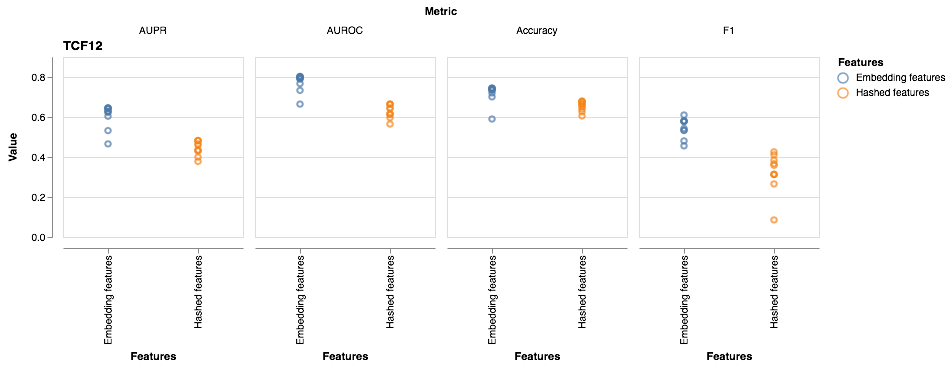

In [39]:
import altair as alt

charts = [alt.Chart(tidy_df[tidy_df.Factor == factor]).mark_point().encode(
    x='Features:N',
    y='Value:Q',
    color='Features:N',
    column='Metric:N'
).properties(
    width=180,
    height=180,
    title=factor
) for factor in embedded_results_dict]

charts[0]
#charts[0] & charts[1] & charts[2] & charts[3] & charts[4]

In [44]:
base = alt.Chart(tidy_df).mark_point().encode(
    x='Metric:N',
    y='Value:Q',
    color='Features:N',
    column="Factor:N"
).properties(
    height=180,
    width=180)
base.save("factors.svg")

ImportError: selenium package is required for saving chart as svg